In [38]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Imbalance handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Explainability
import shap

# Save model
import joblib

pd.set_option("display.max_columns", None)

In [40]:
df = pd.read_csv("frauddetection.csv")
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [41]:
drop_cols = [
    "policy_number",
    "insured_zip",
    "incident_city",
    "_c39"
]

df.drop(columns=drop_cols, inplace=True)

In [42]:
df["policy_bind_date"] = pd.to_datetime(df["policy_bind_date"])
df["incident_date"] = pd.to_datetime(df["incident_date"])

df["policy_bind_year"] = df["policy_bind_date"].dt.year
df["incident_year"] = df["incident_date"].dt.year
df["incident_month"] = df["incident_date"].dt.month

df.drop(columns=["policy_bind_date", "incident_date"], inplace=True)

In [43]:
df["fraud_reported"] = df["fraud_reported"].map({"Y": 1, "N": 0})

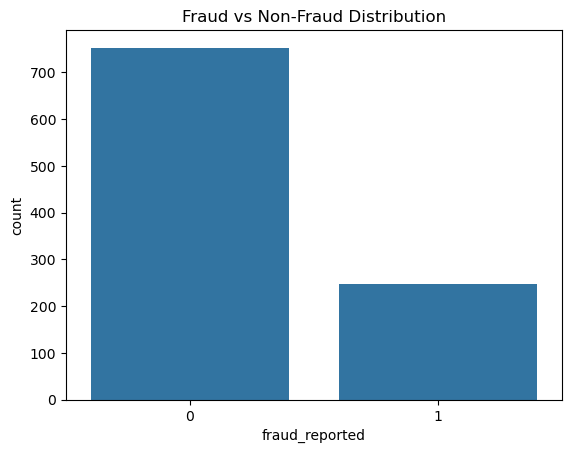

In [44]:
sns.countplot(x="fraud_reported", data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

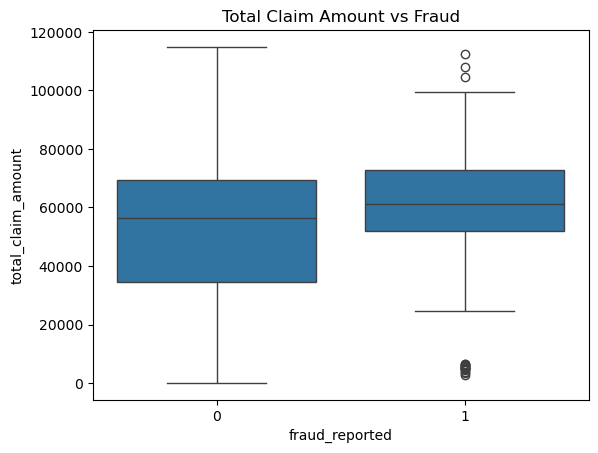

In [46]:
sns.boxplot(x="fraud_reported", y="total_claim_amount", data=df)
plt.title("Total Claim Amount vs Fraud")
plt.show()

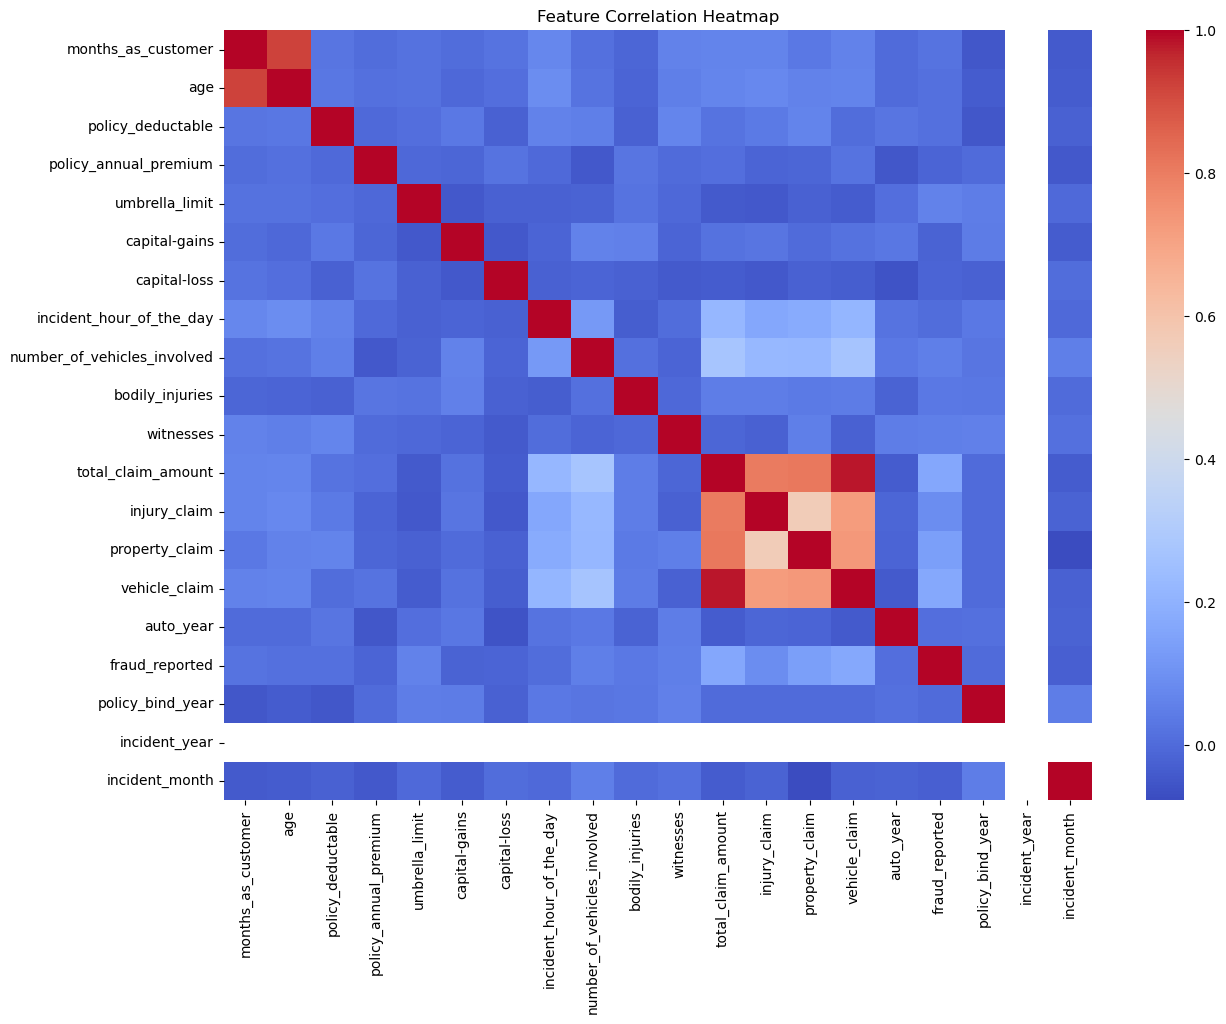

In [47]:
plt.figure(figsize=(14,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [48]:
X = df.drop("fraud_reported", axis=1)
y = df["fraud_reported"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [49]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [51]:
rf_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42
    ))
])

In [52]:
xgb_pipeline = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=3,
        random_state=42
    ))
])

In [53]:
models = {
    "RandomForest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))


RandomForest
Accuracy: 0.79
Precision: 0.6129032258064516
Recall: 0.3877551020408163
F1: 0.475
ROC-AUC: 0.848763346398162

XGBoost
Accuracy: 0.795
Precision: 0.5769230769230769
Recall: 0.6122448979591837
F1: 0.594059405940594
ROC-AUC: 0.8317340181105555


In [54]:
param_grid = {
    "model__max_depth": [4, 6, 8],
    "model__learning_rate": [0.05, 0.1],
    "model__n_estimators": [200, 300]
}

grid = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print(grid.best_params_)

{'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 200}


In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    best_model.fit(X_tr, y_tr)
    preds = best_model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(y_val, preds))

print("Mean CV ROC-AUC:", np.mean(scores))

Mean CV ROC-AUC: 0.8602765946175037


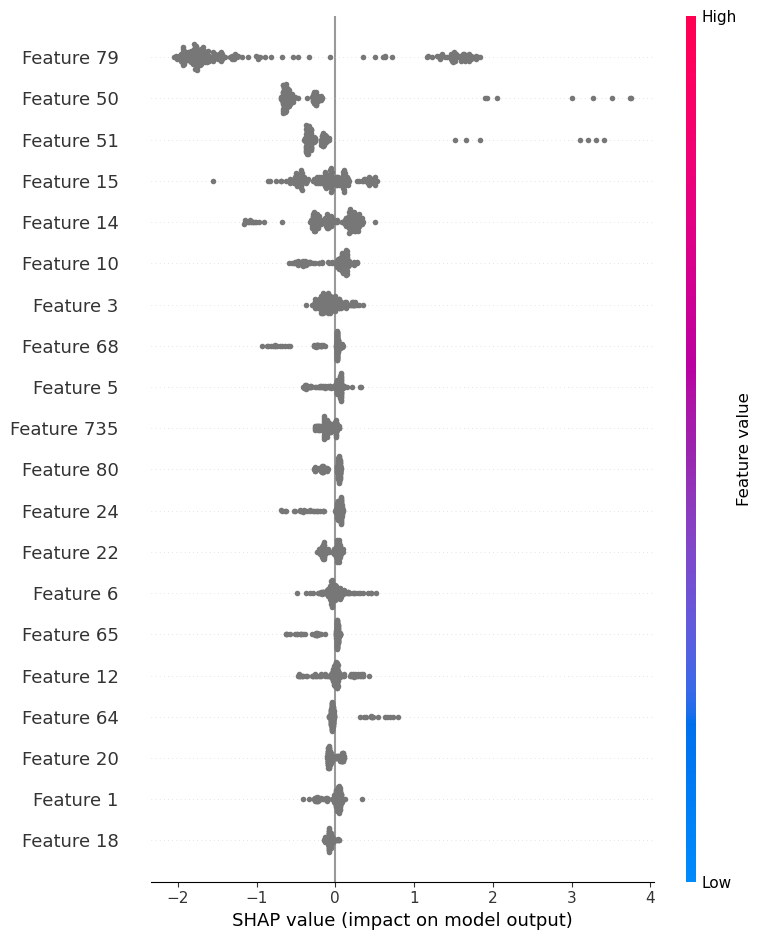

In [56]:
explainer = shap.TreeExplainer(
    best_model.named_steps["model"]
)

X_transformed = best_model.named_steps["preprocess"].transform(X_test)
shap_values = explainer.shap_values(X_transformed)

shap.summary_plot(shap_values, X_transformed)

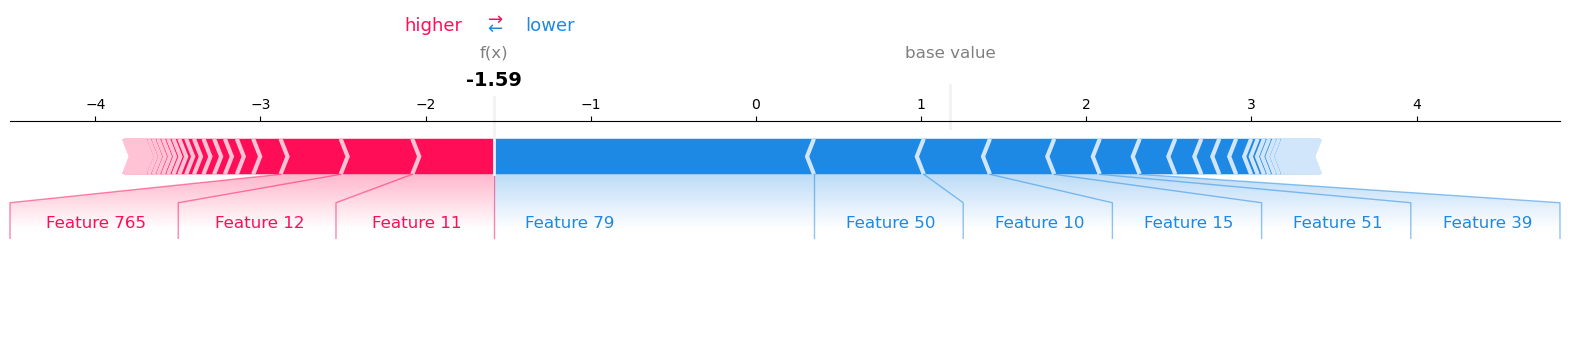

In [57]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    matplotlib=True
)

In [58]:
def risk_score(prob):
    if prob >= 0.75:
        return "High Risk"
    elif prob >= 0.40:
        return "Medium Risk"
    else:
        return "Low Risk"

In [59]:
probs = best_model.predict_proba(X_test)[:,1]
risk_levels = [risk_score(p) for p in probs]

pd.DataFrame({
    "Fraud Probability": probs,
    "Risk Level": risk_levels
}).head()

,Fraud Probability,Risk Level
0,0.169659,Low Risk
1,0.575978,Medium Risk
2,0.054112,Low Risk
3,0.733133,Medium Risk
4,0.059179,Low Risk


In [61]:
total_claims = len(probs)
fraud_pct = (np.sum(probs > 0.5) / total_claims) * 100
high_risk = np.sum(probs > 0.75)

In [62]:
joblib.dump(best_model, "fraud_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']